# Lab 7: Twitter Makes Us Sentimental

Wyatt Saltzman and Landon Wood  
Dr. Larson  
CS 7324  
December 13th, 2023

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
%matplotlib inline

print('Numpy version: ', np.__version__)
print('Tensorflow version: ', tf.__version__)

Numpy version:  1.24.3
Tensorflow version:  2.13.0


For this lab, we will be using the text-only [Sentiment140 dataset](https://www.kaggle.com/datasets/kazanova/sentiment140) from Kaggle. This dataset contains 1,600,000 tweets collected from the Twitter API. Below is an example of some of the rows in the dataset:

In [2]:
# Load the data
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"

df = pd.read_csv('Data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Out of the provided columns, we will only need "sentiment" and "text" to classify sentiment in the tweets. Sentiment is the target variable. IDs, date information and the username of the individual who sent the tweet is irrelevant. The flag column refers to how the data was collected and is also irrelevant. Therefore, we will drop these columns.

Additionally, the dataset has 3 sentiment values:

 - 0: Negative
 - 2: Neutral
 - 4: Positive

We don't particularly find any value in classifying a tweet as neutral, so we will only move forward with positive and negative values of sentiment. Additionally, we will convert all of the 4s for positive sentiment to 1s to format the problem as a more classic binary classification problem.

In [3]:
df = df[['sentiment', 'text']]
df['sentiment'] = df['sentiment'].replace(4, 1)
NUM_CLASSES = 1

Additionally, with sequential networks, 1.6 million records will take a considerably long amount of time to train. Therefore, we will reduce the dataset size to 50,000, with a 50-50 class balance. We can always use more records later if we feel the need to.

In [4]:
# reduce size of dataset to 50,000 with equal number of positive and negative tweets
df_pos = df[df['sentiment'] == 1].sample(25000)
df_neg = df[df['sentiment'] == 0].sample(25000)
df = pd.concat([df_pos, df_neg], axis=0).reset_index(drop=True)

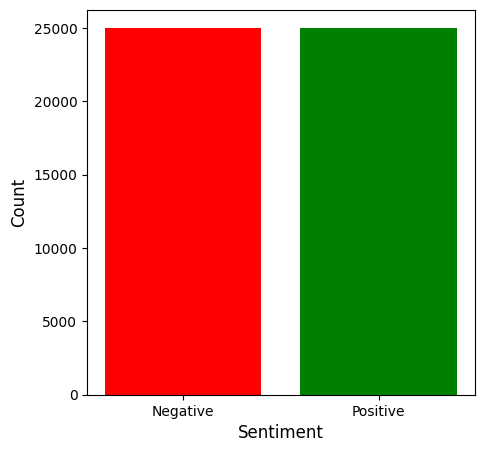

In [5]:
# plot the distribution of positive and negative sentiment

count = df['sentiment'].value_counts()
plt.figure(figsize=(5,5))
plt.bar(count.index, count.values, color=['green', 'red'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.xticks(range(len(count.index)), ['Negative', 'Positive'])
plt.show()

### Evaluation Metric

Our evaluation metric of choice for this lab will be classification accuracy. 

Because of the balance we created by sampling postiive and negative tweets evenly, accuracy becomes more relevant because no class is overrpresented or underrepresented. We can evaluate a model with accuracy to see how it correctly classifies both classes. Additionally, there is no real penalty for misclassification. If we were operating with something like medical data, where false negatives would be extremely costly and false positives were less costly but still undesirable, then it would make sense to use something that measures precision and recall, like an FBeta score with a higher beta value. However, given the nature of our data, there is no mission-critical penalty for misclassification. We are simply interested in how well we can identify the sentiment of a tweet.

The goal of sentiment analysis is to correctly classify the sentiment of the records as accurately as possible; the business case is not to avoid misclassification at all costs like it might be with a medical scenario. Therefore, we feel that accuracy is the correct evaluation metric for this lab.

### Preprocessing

Now, we apply several preprocessing steps to each record:

 - Convert text to lowercase.
 - Replace any instances of URLs with a "URL" token.
 - Replace any instance of a user @'ing another user with a "USER" token.
 - Replace any instances of an eomji with its corresponding unicode representation.
 - Replace any contractions with the expanded contraction, i.e. turning "you're" into "you are".
 - Remove any non-alphanumeric characters.

In [6]:
import re
import contractions

def preprocessing(tweet):
    # Convert tweet to lower case
    tweet = tweet.lower()
    
    # Replace URLs with token
    tweet = re.sub(r'http\S+|www\S+|https\S+', 'URL', tweet)
    
    # Replace user handles with token
    tweet = re.sub(r'@\w+', 'USER', tweet)

    # Replace emojis with token (basic example)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('EMOJI', tweet)
    
    # Replace contractions with their expansions
    tweet = contractions.fix(tweet)
    
    # Remove non-alphanumeric characters
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    
    return tweet


In [7]:
%%time
df['processed_text'] = df['text'].apply(preprocessing)

CPU times: total: 703 ms
Wall time: 709 ms


In [8]:
# Print out 10 samples of the original and processed text
for i in range(30,40):
    print('Original text: ', df['text'][i])
    print('Processed text: ', df['processed_text'][i])
    print()

Original text:  STILL watching Law&amp;Order: SVU + texting my bffmfl 
Processed text:  still watching lawamporder svu  texting my bffmfl 

Original text:  @wellerwishes  sitting next to me, being a bossy girl, like always 
Processed text:  USER  sitting next to me being a bossy girl like always 

Original text:  I hate this iPhone keypad thing.. Tryin to sleep .. &amp; listening to &quot;love is gone&quot;  nighttt twitter world!
Processed text:  i hate this iphone keypad thing tryin to sleep  amp listening to quotlove is gonequot  nighttt twitter world

Original text:  Woke up in a great mood today 
Processed text:  woke up in a great mood today 

Original text:  Victoria secret is the most amaaaziiinngg store on the planet 
Processed text:  victoria secret is the most amaaaziiinngg store on the planet 

Original text:  Headed to work with coffee in hand 
Processed text:  headed to work with coffee in hand 

Original text:  just finished morning prayer time. going through the message

##### TODO: add'l analysis on what preprocessing exposes? Inconsistent between different train/test splits, so could return to this before submission for add/' context

In [9]:
data_pos = df[df['sentiment'] == 1]['processed_text'].values
data_neg = df[df['sentiment'] == 0]['processed_text'].values

In [10]:
# create a word cloud for positive and negative tweets
from wordcloud import WordCloud

# Create positive and negative word lists for creating word clouds
data_pos = list(df[df['sentiment'] == 1]['processed_text'])
data_neg = list(df[df['sentiment'] == 0]['processed_text'])

def plot_wordcloud(data, color='black'):
    wordcloud = WordCloud(background_color=color, max_words=1000, width=1600, height=800, random_state=42, collocations=False).generate(" ".join(data))
    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    

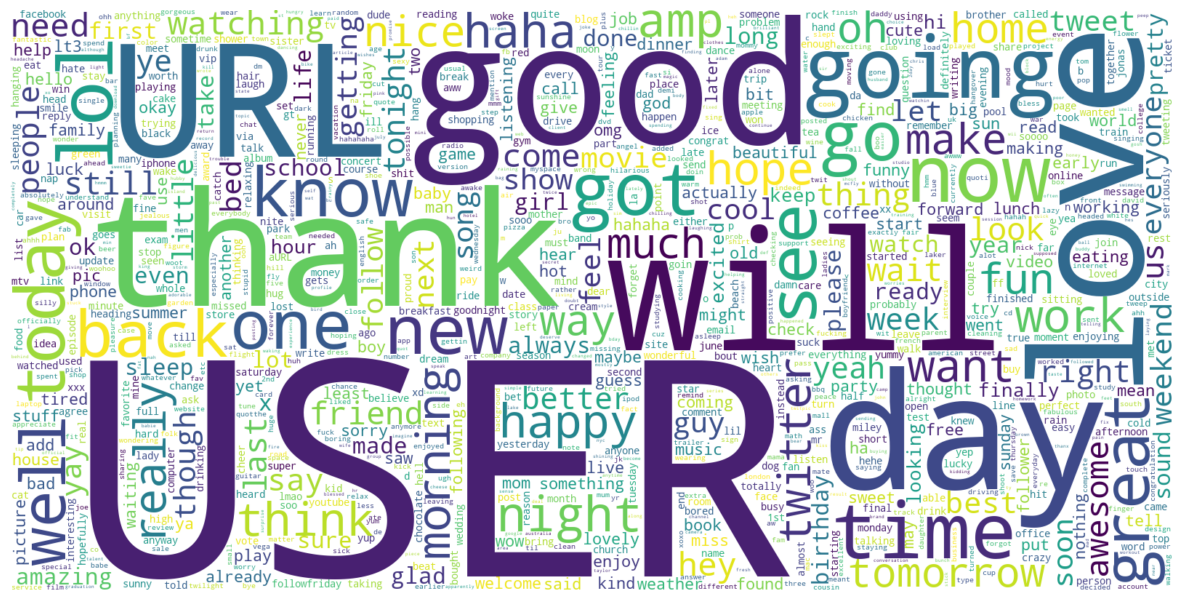

In [11]:
plot_wordcloud(data_pos, 'white')

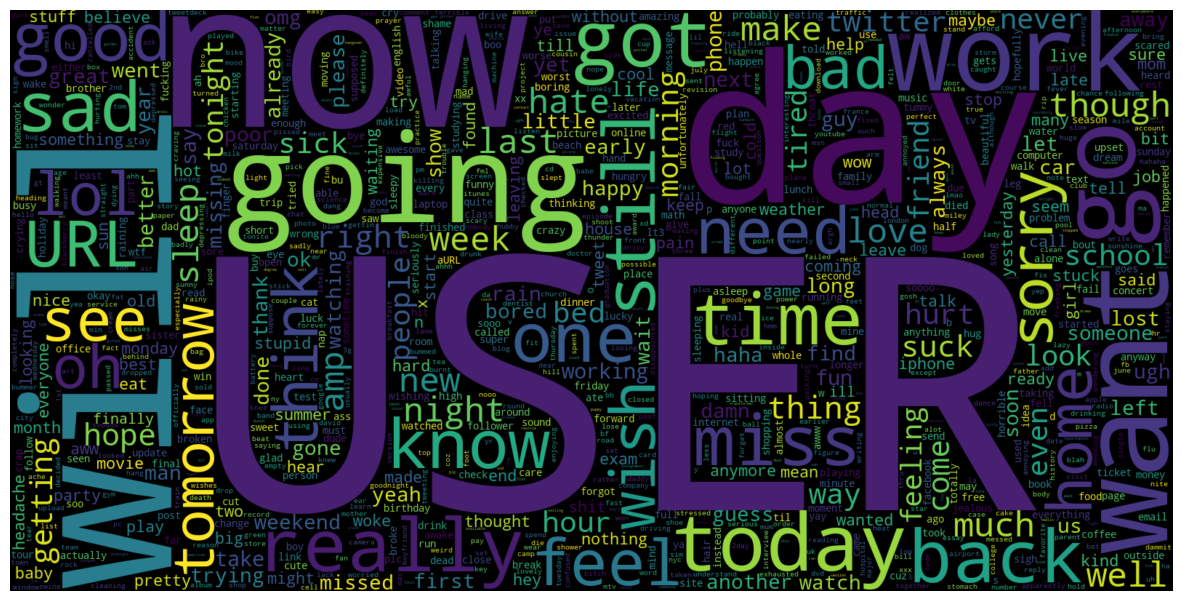

In [12]:
plot_wordcloud(data_neg)

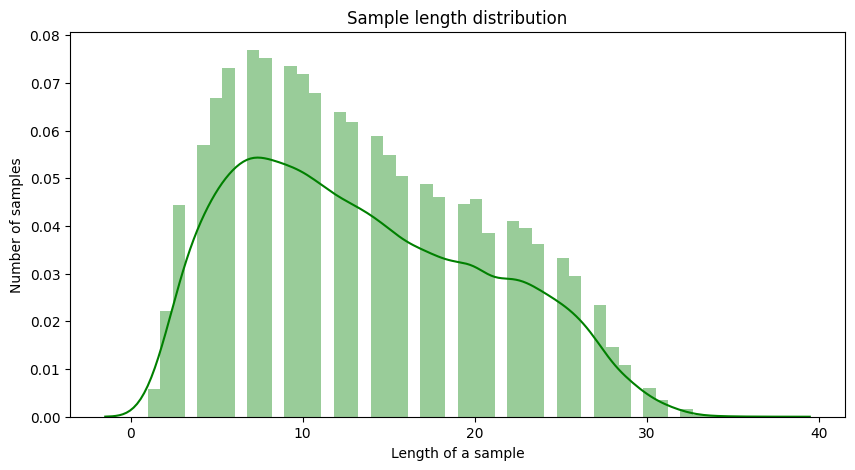

In [13]:
# plot the distribution of tweet lengths
import warnings
warnings.simplefilter('ignore', UserWarning)

plt.figure(figsize=(10, 5))
sns.distplot([len(s.split()) for s in df['processed_text']], color='green')
plt.xlabel('Length of a sample')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

In [14]:
# find the max length of a tweet
max_len = max([len(s.split()) for s in df['processed_text']])
print('Max length of a tweet: ', max_len, 'tokens.')

Max length of a tweet:  37 tokens.


Now, we will set up our vocabulary by tokenizing the text and storing the tokens as sequences of integers.

We chose to set the max word length of a record to 36, because from the distribution above and snippet above, we can see that the longest tweets contain 36 tokens. This means that we will also pad all other sequences to be of length 36.

##### TODO: Update this for submission, the max length records varies from 35-38.

In [15]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df['processed_text'].values
y = df['sentiment'].values

# Limit the sequence to 35 words
MAX_LEN = max_len
VOCAB_SIZE = 60000

# Tokenize the text
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>', lower=False)
tokenizer.fit_on_texts(X)

# Save as sequences with integers instead of words
sequences = tokenizer.texts_to_sequences(X)

# Set vocab size to number of words if number of words < 60,000
word_index = tokenizer.word_index
VOCAB_SIZE = (len(word_index) + 1) if VOCAB_SIZE > (len(word_index) + 1) else VOCAB_SIZE 
top_words = min((len(word_index) + 1, VOCAB_SIZE)) # Keep all of the top words
print('Found %s unique tokens. Distilled to %s.' % (len(word_index) + 1, top_words))

# Pad the sequences to be 36 words long
X = pad_sequences(sequences, maxlen=MAX_LEN)
y_ohe = keras.utils.to_categorical(y, 2)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(VOCAB_SIZE)

Found 42359 unique tokens. Distilled to 42359.
Shape of data tensor: (50000, 37)
Shape of label tensor: (50000, 2)
42359
CPU times: total: 1.45 s
Wall time: 1.51 s


### Splitting the Data

Given the size of our dataset, we will opt for a simple train / test split of 80% / 20%. We feel comfortable training a model on 40,000 instances and then testing the model with 10,000 instances. If our dataset was smaller, say only 5,000 - 10,000 instances total, then we might want to perform some additional validation such as k-fold cross validation. However, for a dataset of this size, we believe we can train it as-is.

We will not perform any sort of stratified selection or synthetic sampling on the train / test split as the data we pulled already has an even class balance. Additionally, in a real-world scenario, it is highly unlikely that there would be a perfect 50% / 50% class balance on raw data taken from the internet, so we want our model to mirror a realistic implementation when we test it. 

X_train shape:  (40000, 37) Label shape:  (40000, 2)


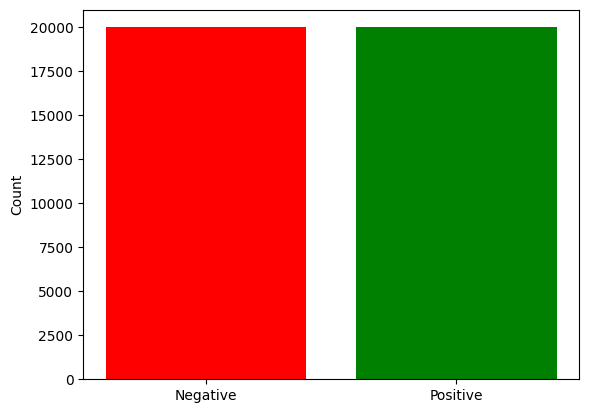

In [16]:
from sklearn.model_selection import train_test_split

# split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe,test_size=0.2, random_state=42, stratify=y_ohe)

# print out some stats of the data
print('X_train shape: ', X_train.shape, 'Label shape: ', y_train.shape)
count = np.sum(y_train, axis=0)
plt.bar(range(2), count, color=['red', 'green'])
plt.xticks(range(2), ['Negative', 'Positive'])
plt.ylabel('Count')
plt.show()

### Embedding

We decided to use glove's twitter embeddings because we are using a Twitter dataset.

In [17]:
%%time
EMBEDDING_SIZE = 100

embeddings_index = {}
f = open('Embeddings/glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 1193514 word vectors.
Embedding shape:  (42359, 100)
Total words found:  28124
Percentage:  66.39439080242687
CPU times: total: 26.9 s
Wall time: 27 s


In [18]:
from tensorflow.keras.layers import Embedding

# save the embedding layer as a variable
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

### CNN #1

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)

preds = Dense(2, activation='softmax')(x)

cnn = Model(sequence_input, preds)

cnn.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(cnn.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 37)]              0         
                                                                 
 embedding (Embedding)       (None, 37, 100)           4235900   
                                                                 
 conv1d (Conv1D)             (None, 33, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 16, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 128)           82048     
                                                             

In [20]:
history_cnn = []
tmp = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
history_cnn.append(tmp)

Epoch 1/10
313/313 [==============================] - 7s 19ms/step - loss: 0.5816 - accuracy: 0.6910 - val_loss: 0.5389 - val_accuracy: 0.7254
Epoch 2/10
313/313 [==============================] - 6s 19ms/step - loss: 0.5128 - accuracy: 0.7509 - val_loss: 0.5122 - val_accuracy: 0.7477
Epoch 3/10
313/313 [==============================] - 6s 18ms/step - loss: 0.4802 - accuracy: 0.7709 - val_loss: 0.5200 - val_accuracy: 0.7383
Epoch 4/10
313/313 [==============================] - 6s 19ms/step - loss: 0.4523 - accuracy: 0.7871 - val_loss: 0.5180 - val_accuracy: 0.7495
Epoch 5/10
313/313 [==============================] - 6s 18ms/step - loss: 0.4191 - accuracy: 0.8082 - val_loss: 0.5226 - val_accuracy: 0.7513
Epoch 6/10
313/313 [==============================] - 6s 18ms/step - loss: 0.3856 - accuracy: 0.8260 - val_loss: 0.5339 - val_accuracy: 0.7431
Epoch 7/10
313/313 [==============================] - 6s 18ms/step - loss: 0.3571 - accuracy: 0.8405 - val_loss: 0.5638 - val_accuracy: 0.7375

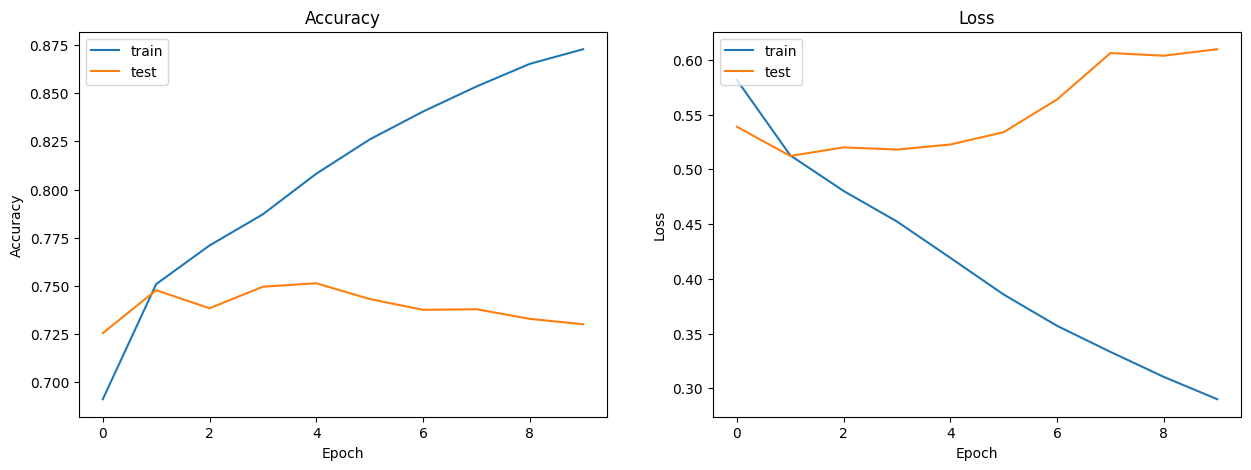

In [21]:
# plot the accuracy and loss of the model

# combine the history from training together
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_cnn])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transformer #1

In [34]:
# From notebook 13a, Sequence Basics [experimental]

from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer

# The transformer architecture 
class TransformerBlock(Layer): # inherit from Keras Layer
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.2):
        super().__init__()
        # setup the model heads and feedforward network
        self.att = MultiHeadAttention(num_heads=num_heads, 
                                      key_dim=embed_dim)
        
        # make a two layer network that processes the attention
        self.ffn = Sequential()
        self.ffn.add( Dense(ff_dim, activation='relu') )
        self.ffn.add( Dense(embed_dim) )
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        # apply the layers as needed (similar to PyTorch)
        
        # get the attention output from multi heads
        # Using same inpout here is self-attention
        # call inputs are (query, value, key) 
        # if only two inputs given, value and key are assumed the same
        attn_output = self.att(inputs, inputs)
        
        # create residual output, with attention
        out1 = self.layernorm1(inputs + attn_output)
        
        # apply dropout if training
        out1 = self.dropout1(out1, training=training)
        
        # place through feed forward after layer norm
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        
        # apply dropout if training
        out2 = self.dropout2(out2, training=training)
        #return the residual from Dense layer
        return out2
    
class GloveTokenAndPositionEmbedding(Layer):
    def __init__(self):
        super().__init__()
        # create two embeddings 
        # one for processing the tokens (words)
        self.token_emb = Embedding(len(word_index) + 1,
                                   EMBEDDING_SIZE,
                                   weights=[embedding_matrix],
                                   input_length=MAX_LEN,
                                   trainable=False)
        # another embedding for processing the position
        self.pos_emb = Embedding(MAX_LEN,
                                 EMBEDDING_SIZE,
                                 input_length=MAX_LEN,
                                 trainable=True)

    def call(self, x):
        # create a static position measure (input)
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # positions now goes from 0 to 500 (for IMdB) by 1
        positions = self.pos_emb(positions)# embed these positions
        x = self.token_emb(x) # embed the tokens
        return x + positions # add embeddngs to get final embedding

In [35]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
temp = GloveTokenAndPositionEmbedding()(inputs)
temp = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(temp)

temp = GlobalAveragePooling1D()(temp)
temp = Dropout(0.2)(temp)
temp = Dense(64, activation='relu')(temp)
temp = Dropout(0.2)(temp)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(temp)

model_xformer = Model(inputs=inputs, outputs=outputs)
print(model_xformer.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 37)]              0         
                                                                 
 glove_token_and_position_e  (None, 37, 100)           4239600   
 mbedding_1 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_1 (Trans  (None, 37, 100)           168232    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_2  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_9 (Dropout)         (None, 100)               0   

In [36]:
model_xformer.compile(optimizer='adam', 
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])


history_xformer = []
tmp = model_xformer.fit(
    X_train, y_train, batch_size=64, epochs=10, 
    validation_data=(X_test, y_test)
)
history_xformer.append(tmp)

Epoch 1/10
625/625 [==============================] - 28s 43ms/step - loss: 0.5186 - accuracy: 0.7445 - val_loss: 0.4816 - val_accuracy: 0.7708
Epoch 2/10
625/625 [==============================] - 26s 41ms/step - loss: 0.4824 - accuracy: 0.7712 - val_loss: 0.4736 - val_accuracy: 0.7724
Epoch 3/10
625/625 [==============================] - 26s 41ms/step - loss: 0.4696 - accuracy: 0.7800 - val_loss: 0.4591 - val_accuracy: 0.7820
Epoch 4/10
625/625 [==============================] - 27s 43ms/step - loss: 0.4586 - accuracy: 0.7863 - val_loss: 0.4553 - val_accuracy: 0.7838
Epoch 5/10
625/625 [==============================] - 26s 41ms/step - loss: 0.4527 - accuracy: 0.7882 - val_loss: 0.4634 - val_accuracy: 0.7806
Epoch 6/10
625/625 [==============================] - 26s 42ms/step - loss: 0.4480 - accuracy: 0.7911 - val_loss: 0.4653 - val_accuracy: 0.7862
Epoch 7/10
625/625 [==============================] - 26s 41ms/step - loss: 0.4434 - accuracy: 0.7929 - val_loss: 0.4699 - val_accuracy:

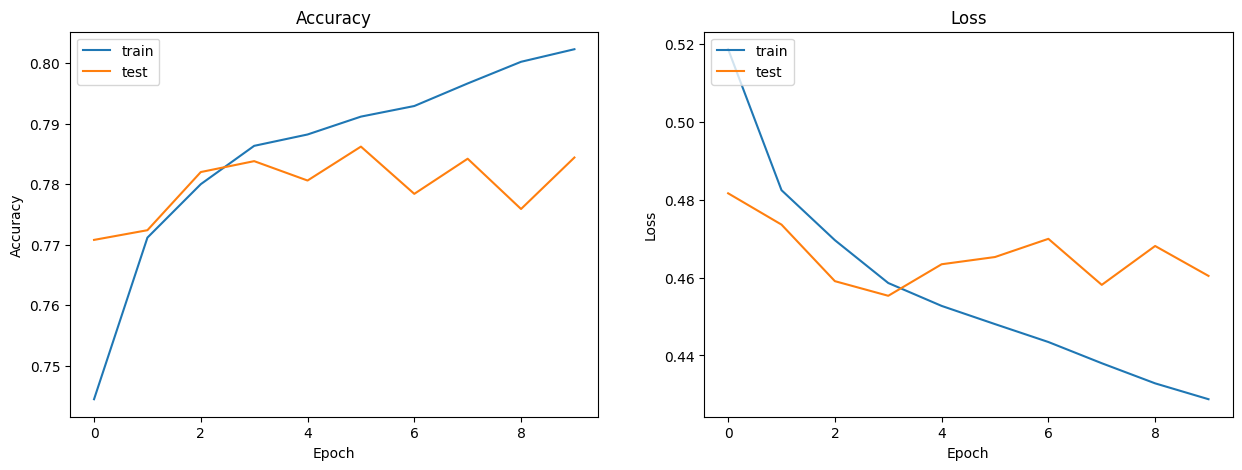

In [38]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Even though the graphs don't look very converged, they are. We tested it for 25 epics and notcied after about 10 epochs the loss begins to rise and the accuracy falls off. This is due to overfitting and why we chose to run this transformer for 10 epochs.

In [39]:
# Helper function to perform a paired t-test statistical comparison between the evaluation metric of two models

from scipy import stats

def paired_t_test(model1_history, model2_history):
    
    # Perform a paired t-test
    t_statistic, p_value = stats.ttest_rel(model1_history.history['val_accuracy'], model2_history.history['val_accuracy'])
    
    # Print the results
    print(f"Paired t-test results:")
    print(f"T-statistic: {t_statistic}")
    print(f"P-value: {p_value}")
    
    # Check for statistical significance with alpha = 0.05, denoting a 95% confidence level
    alpha = 0.05
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between model 1 and model 2.")
    else:
        print("Fail to reject the null hypothesis: No significant difference found between model 1 and model 2.")

In [41]:
paired_t_test(history_cnn[0], history_xformer[0])

Paired t-test results:
T-statistic: -14.64347406722588
P-value: 1.3899719482422688e-07
Reject the null hypothesis: There is a significant difference between model 1 and model 2.


For the next CNN and Transformer we are going to use the twitter embedding with 200 dimensions.

In [153]:
%%time
EMBEDDING_SIZE = 200

embeddings_index = {}
f = open('Embeddings/glove.twitter.27B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 1193514 word vectors.
Embedding shape:  (42923, 200)
Total words found:  28239
Percentage:  65.78990284928827
CPU times: user 22.2 s, sys: 1.01 s, total: 23.2 s
Wall time: 23.6 s


In [154]:
# save the embedding layer as a variable
embedding_layer_200d = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

### CNN #2

In [161]:
sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = embedding_layer_200d(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = MaxPooling1D(2)(x)  # Adjusted pooling window size
x = Dropout(0.2)(x)
x = Conv1D(128, 5, activation='relu')(x)

x = GlobalAveragePooling1D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)

preds = Dense(2, activation='softmax')(x)

cnn2 = Model(sequence_input, preds)

cnn2.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

print(cnn2.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 37)]              0         
                                                                 
 embedding_13 (Embedding)    (None, 37, 200)           8584600   
                                                                 
 conv1d_16 (Conv1D)          (None, 33, 128)           128128    
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 16, 128)           0         
 ng1D)                                                           
                                                                 
 dropout_34 (Dropout)        (None, 16, 128)           0         
                                                                 
 conv1d_17 (Conv1D)          (None, 12, 128)           82048     
                                                           

In [162]:
cnn2_history = []
tmp = cnn2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
cnn2_history.append(tmp)

Epoch 1/10
313/313 [==============================] - 18s 42ms/step - loss: 0.5772 - accuracy: 0.6899 - val_loss: 0.5158 - val_accuracy: 0.7483
Epoch 2/10
313/313 [==============================] - 7s 21ms/step - loss: 0.5065 - accuracy: 0.7521 - val_loss: 0.5355 - val_accuracy: 0.7353
Epoch 3/10
313/313 [==============================] - 7s 21ms/step - loss: 0.5290 - accuracy: 0.7395 - val_loss: 0.5355 - val_accuracy: 0.7382
Epoch 4/10
313/313 [==============================] - 7s 21ms/step - loss: 0.6469 - accuracy: 0.7085 - val_loss: 0.5649 - val_accuracy: 0.7287
Epoch 5/10
313/313 [==============================] - 7s 21ms/step - loss: 2.1626 - accuracy: 0.6800 - val_loss: 3.3176 - val_accuracy: 0.6629
Epoch 6/10
313/313 [==============================] - 7s 21ms/step - loss: 5.1003 - accuracy: 0.6904 - val_loss: 10.2994 - val_accuracy: 0.7173
Epoch 7/10
313/313 [==============================] - 7s 21ms/step - loss: 11.7478 - accuracy: 0.6922 - val_loss: 13.5245 - val_accuracy: 0.

In [163]:
tmp = cnn2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=128)
cnn2_history.append(tmp)

Epoch 1/10
313/313 [==============================] - 7s 21ms/step - loss: 147.9248 - accuracy: 0.6854 - val_loss: 244.0301 - val_accuracy: 0.6207
Epoch 2/10
313/313 [==============================] - 6s 20ms/step - loss: 135.6215 - accuracy: 0.6880 - val_loss: 59.5535 - val_accuracy: 0.7441
Epoch 3/10
313/313 [==============================] - 6s 20ms/step - loss: 229.6767 - accuracy: 0.6877 - val_loss: 128.9247 - val_accuracy: 0.6688
Epoch 4/10
313/313 [==============================] - 6s 20ms/step - loss: 300.7896 - accuracy: 0.6844 - val_loss: 175.1279 - val_accuracy: 0.7396
Epoch 5/10
313/313 [==============================] - 6s 20ms/step - loss: 398.0562 - accuracy: 0.6844 - val_loss: 640.9561 - val_accuracy: 0.6292
Epoch 6/10
313/313 [==============================] - 6s 20ms/step - loss: 537.2501 - accuracy: 0.6691 - val_loss: 537.6464 - val_accuracy: 0.5537
Epoch 7/10
313/313 [==============================] - 6s 20ms/step - loss: 690.1925 - accuracy: 0.6758 - val_loss: 706.

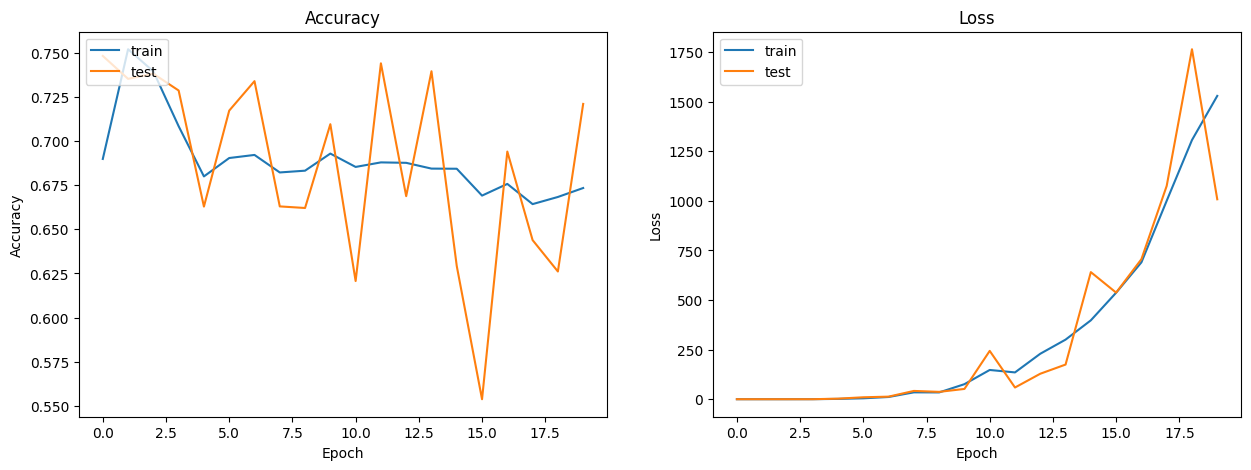

In [164]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in cnn2_history])
    
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transformer #2

In [165]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
temp = GloveTokenAndPositionEmbedding()(inputs)
temp = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(temp)

temp = GlobalAveragePooling1D()(temp)
temp = Dropout(0.2)(temp)
temp = Dense(64, activation='relu')(temp)
temp = Dropout(0.2)(temp)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(temp)

model_xformer2 = Model(inputs=inputs, outputs=outputs)
print(model_xformer2.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 37)]              0         
                                                                 
 glove_token_and_position_e  (None, 37, 200)           8592000   
 mbedding_4 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_5 (Trans  (None, 37, 200)           656432    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 200)               0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_39 (Dropout)        (None, 200)               0  

In [167]:
model_xformer2.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

history_xformer2 = []
tmp = model_xformer2.fit(
    X_train, y_train, batch_size=64, epochs=5, 
    validation_data=(X_test, y_test)
)
history_xformer2.append(tmp)

Epoch 1/5
625/625 [==============================] - 65s 88ms/step - loss: 0.5607 - accuracy: 0.7325 - val_loss: 0.4870 - val_accuracy: 0.7648
Epoch 2/5
625/625 [==============================] - 47s 75ms/step - loss: 0.4871 - accuracy: 0.7638 - val_loss: 0.4934 - val_accuracy: 0.7599
Epoch 3/5
625/625 [==============================] - 47s 75ms/step - loss: 0.4673 - accuracy: 0.7762 - val_loss: 0.4735 - val_accuracy: 0.7721
Epoch 4/5
625/625 [==============================] - 46s 74ms/step - loss: 0.4614 - accuracy: 0.7827 - val_loss: 0.4545 - val_accuracy: 0.7917
Epoch 5/5
625/625 [==============================] - 46s 74ms/step - loss: 0.4520 - accuracy: 0.7861 - val_loss: 0.4595 - val_accuracy: 0.7848


In [169]:
tmp = model_xformer2.fit(
    X_train, y_train, batch_size=64, epochs=5, 
    validation_data=(X_test, y_test)
)
history_xformer2.append(tmp)

Epoch 1/5
625/625 [==============================] - 47s 76ms/step - loss: 0.4472 - accuracy: 0.7917 - val_loss: 0.4685 - val_accuracy: 0.7750
Epoch 2/5
625/625 [==============================] - 47s 75ms/step - loss: 0.4405 - accuracy: 0.7911 - val_loss: 0.4597 - val_accuracy: 0.7815
Epoch 3/5
625/625 [==============================] - 47s 75ms/step - loss: 0.4371 - accuracy: 0.7954 - val_loss: 0.4702 - val_accuracy: 0.7765
Epoch 4/5
625/625 [==============================] - 47s 75ms/step - loss: 0.4322 - accuracy: 0.7959 - val_loss: 0.4634 - val_accuracy: 0.7860
Epoch 5/5
625/625 [==============================] - 47s 75ms/step - loss: 0.4307 - accuracy: 0.7968 - val_loss: 0.4617 - val_accuracy: 0.7858


In [171]:
tmp = model_xformer2.fit(
    X_train, y_train, batch_size=64, epochs=3, 
    validation_data=(X_test, y_test)
)
history_xformer2.append(tmp)

Epoch 1/3
625/625 [==============================] - 47s 75ms/step - loss: 0.4253 - accuracy: 0.7989 - val_loss: 0.4733 - val_accuracy: 0.7862
Epoch 2/3
625/625 [==============================] - 46s 74ms/step - loss: 0.4274 - accuracy: 0.7968 - val_loss: 0.4700 - val_accuracy: 0.7795
Epoch 3/3
625/625 [==============================] - 47s 75ms/step - loss: 0.4348 - accuracy: 0.7922 - val_loss: 0.4697 - val_accuracy: 0.7792


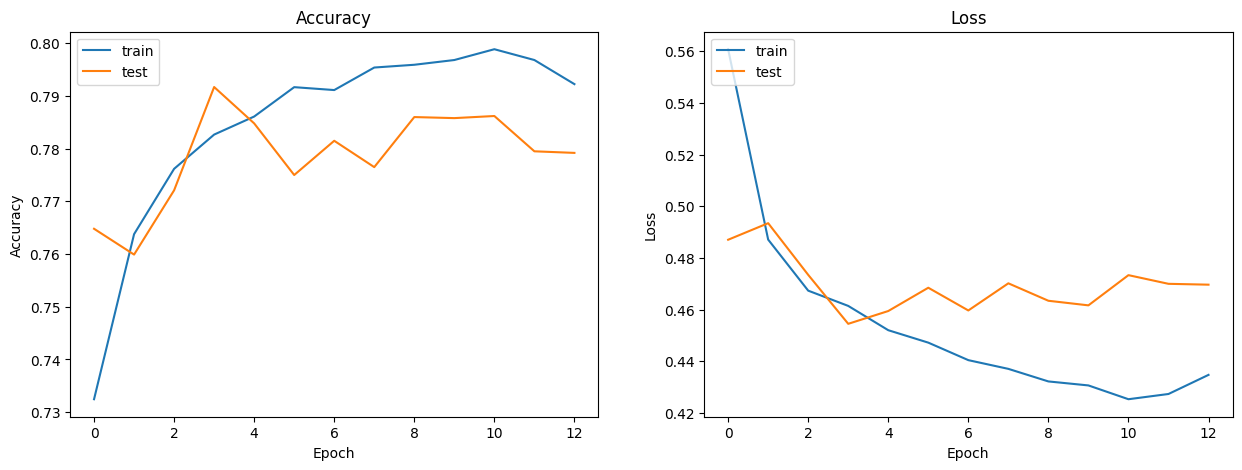

In [172]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer2])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Transformer #3
Adding another layer of attention to Transformer #2

In [173]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer3 = Model(inputs=inputs, outputs=outputs)
model_xformer3.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
print(model_xformer3.summary())

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 37)]              0         
                                                                 
 glove_token_and_position_e  (None, 37, 200)           8592000   
 mbedding_5 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_6 (Trans  (None, 37, 200)           656432    
 formerBlock)                                                    
                                                                 
 transformer_block_7 (Trans  (None, 37, 200)           656432    
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 200)               0  

In [174]:
history_xformer3 = []
tmp = model_xformer3.fit(
    X_train, y_train, batch_size=64, epochs=5, 
    validation_data=(X_test, y_test)
)
history_xformer3.append(tmp)

Epoch 1/5
625/625 [==============================] - 112s 157ms/step - loss: 0.5608 - accuracy: 0.7347 - val_loss: 0.5219 - val_accuracy: 0.7370
Epoch 2/5
625/625 [==============================] - 87s 140ms/step - loss: 0.4894 - accuracy: 0.7675 - val_loss: 0.4924 - val_accuracy: 0.7688
Epoch 3/5
625/625 [==============================] - 87s 139ms/step - loss: 0.4758 - accuracy: 0.7763 - val_loss: 0.4681 - val_accuracy: 0.7800
Epoch 4/5
625/625 [==============================] - 90s 143ms/step - loss: 0.4629 - accuracy: 0.7852 - val_loss: 0.4611 - val_accuracy: 0.7855
Epoch 5/5
625/625 [==============================] - 87s 140ms/step - loss: 0.4560 - accuracy: 0.7854 - val_loss: 0.4709 - val_accuracy: 0.7841


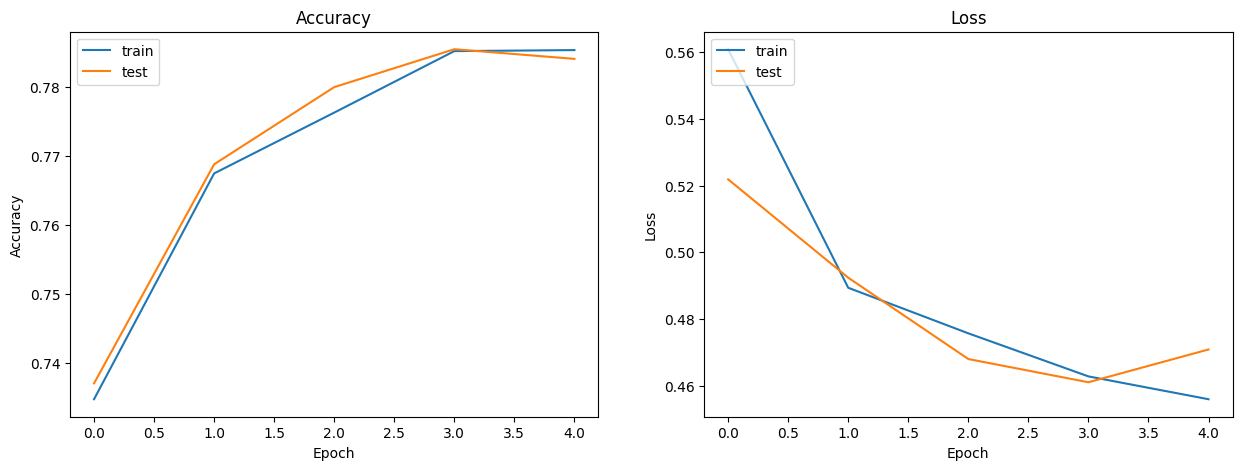

In [194]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer3])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# show converging of all graphs
# compare cnn 1 and cnn2 
# compare xformer 1 and xformer 2
# compare best cnn and best xformer

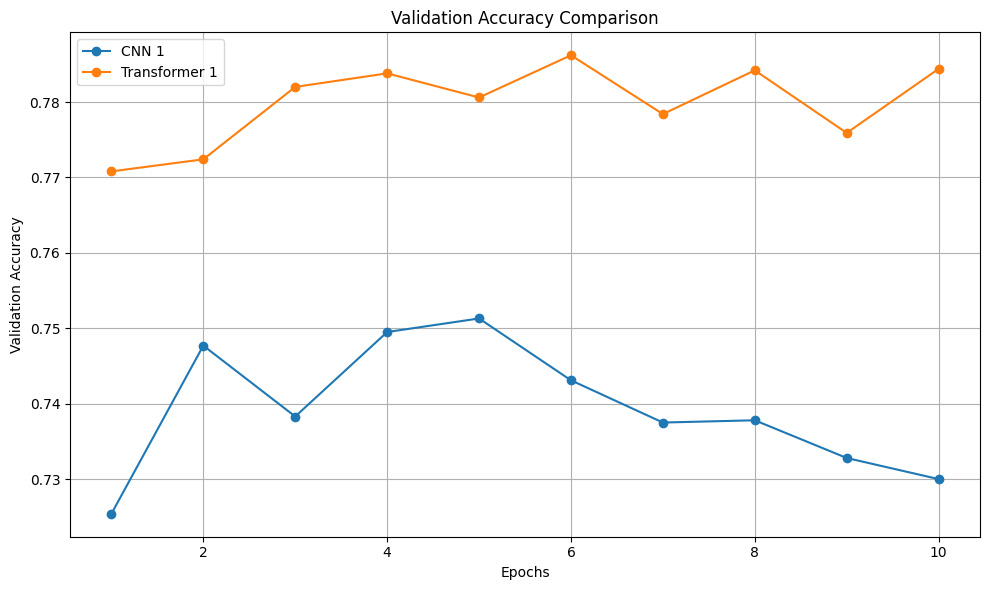

In [55]:
import matplotlib.pyplot as plt

def plot_history(model_histories, model_names):
    plt.figure(figsize=(10, 6))
    
    for i, history in enumerate(model_histories):
        epochs = len(history.history['val_accuracy'])
        plt.plot(range(1, epochs + 1), history.history['val_accuracy'], label=model_names[i], marker='o')
    
    plt.title('Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    plt.show()


# Assuming model1_history, model2_history, model3_history, model4_history, and model5_history contain validation accuracies across epochs
# Replace model1_history, model2_history, model3_history, model4_history, and model5_history with your actual model history dictionaries
model_histories = [history_cnn[0], history_xformer[0]]
model_names = ['CNN 1', 'Transformer 1']

# model_histories = [model1_history, model2_history, model3_history, model4_history, model5_history]
# model_names = ['CNN 1', 'CNN 2', 'Transformer 1', 'Transformer 2', 'Transformer 3']

plot_history(model_histories, model_names)


### Exceptional Work: ConceptNet Numberbatch Embeddings

In [57]:
%%time
EMBEDDING_SIZE = None
conceptnet_embedding_index = {}
with open('Embeddings/numberbatch-en-19.08.txt', encoding='utf-8') as f:
    first_line = f.readline().split()
    EMBEDDING_SIZE = int(first_line[1])

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        conceptnet_embedding_index[word] = coefs

print('Found %s word vectors.' % len(conceptnet_embedding_index))

found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_SIZE))
for word, i in word_index.items():
    embedding_vector = conceptnet_embedding_index.get(word)
    if embedding_vector is not None:
        found_words += 1
        embedding_matrix[i] = embedding_vector

print('Embedding shape: ', embedding_matrix.shape)
print('Total words found: ', found_words)
print("Percentage: ", found_words / embedding_matrix.shape[0] * 100)

Found 516782 word vectors.
Embedding shape:  (42359, 300)
Total words found:  22670
Percentage:  53.51873273684459
CPU times: total: 30.2 s
Wall time: 30.3 s


In [58]:
embedding_layer_conceptnet = Embedding(len(word_index) + 1,
                            EMBEDDING_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_LEN,
                            trainable=False)

In [59]:
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = Input(shape=(X_train.shape[1],))
x = GloveTokenAndPositionEmbedding()(inputs)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)
x = TransformerBlock(EMBEDDING_SIZE, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(2, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)

model_xformer_conceptnet = Model(inputs=inputs, outputs=outputs)
model_xformer_conceptnet.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])
print(model_xformer_conceptnet.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 37)]              0         
                                                                 
 glove_token_and_position_e  (None, 37, 300)           12718800  
 mbedding_2 (GloveTokenAndP                                      
 ositionEmbedding)                                               
                                                                 
 transformer_block_2 (Trans  (None, 37, 300)           1464632   
 formerBlock)                                                    
                                                                 
 transformer_block_3 (Trans  (None, 37, 300)           1464632   
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_3  (None, 300)               0   

In [60]:
history_xformer_conceptnet = []
tmp = model_xformer_conceptnet.fit(
    X_train, y_train, batch_size=64, epochs=5, 
    validation_data=(X_test, y_test)
)
history_xformer_conceptnet.append(tmp)

Epoch 1/5
118/625 [====>.........................] - ETA: 2:21 - loss: 0.6290 - accuracy: 0.6429

KeyboardInterrupt: 

In [204]:
tmp = model_xformer_conceptnet.fit(
    X_train, y_train, batch_size=64, epochs=3, 
    validation_data=(X_test, y_test)
)
history_xformer_conceptnet.append(tmp)

Epoch 1/3
625/625 [==============================] - 128s 205ms/step - loss: 0.4784 - accuracy: 0.7730 - val_loss: 0.5067 - val_accuracy: 0.7540
Epoch 2/3
625/625 [==============================] - 125s 200ms/step - loss: 0.4794 - accuracy: 0.7717 - val_loss: 0.5741 - val_accuracy: 0.7103
Epoch 3/3
625/625 [==============================] - 125s 200ms/step - loss: 0.4774 - accuracy: 0.7739 - val_loss: 0.4998 - val_accuracy: 0.7678


In [206]:
tmp = model_xformer_conceptnet.fit(
    X_train, y_train, batch_size=64, epochs=3, 
    validation_data=(X_test, y_test)
)
history_xformer_conceptnet.append(tmp)

Epoch 1/3
625/625 [==============================] - 124s 199ms/step - loss: 0.4773 - accuracy: 0.7705 - val_loss: 0.4692 - val_accuracy: 0.7787
Epoch 2/3
625/625 [==============================] - 126s 202ms/step - loss: 0.4784 - accuracy: 0.7696 - val_loss: 0.5038 - val_accuracy: 0.7619
Epoch 3/3
625/625 [==============================] - 125s 201ms/step - loss: 0.5126 - accuracy: 0.7533 - val_loss: 0.5317 - val_accuracy: 0.7424


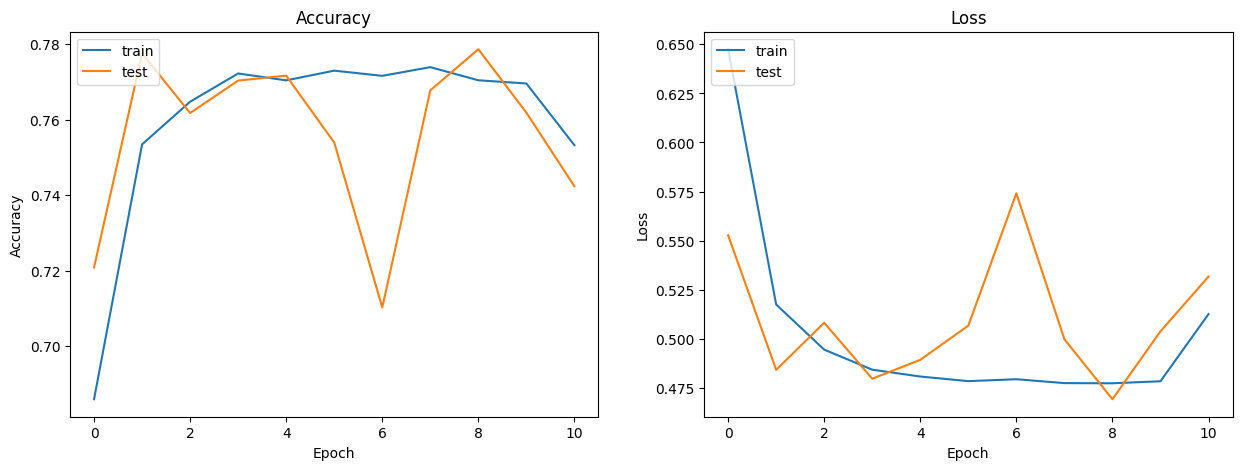

In [207]:
combined = dict()
for key in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
    combined[key] = np.hstack([h.history[key] for h in history_xformer_conceptnet])

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(combined['accuracy'], label='Training')
plt.plot(combined['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'], label='Training')
plt.plot(combined['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()